# Permutation Channel Importance

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import random
import glob
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from huggingface_hub import hf_hub_download

# Load python files
import sys
sys.path.append('../modelling')
from datasets import SegmentationDataset, ImageDataset

In [3]:
# Load paths
paths = glob.glob('../../data/LICS/test/*')
print(len(paths))

100


In [4]:
# Create dataset object
lics_dataset = SegmentationDataset(paths) 

# Load first instance
bands, target = lics_dataset.__getitem__(0)

In [5]:
# We have 7 spectral bands
bands.shape

torch.Size([7, 256, 256])

In [13]:
# Shuffle the nir band
nir = bands[3]

nir = np.asarray(nir)
nir = nir.ravel()
np.random.shuffle(nir)

nir.resize(256,256)
bands[3] = torch.tensor(nir)

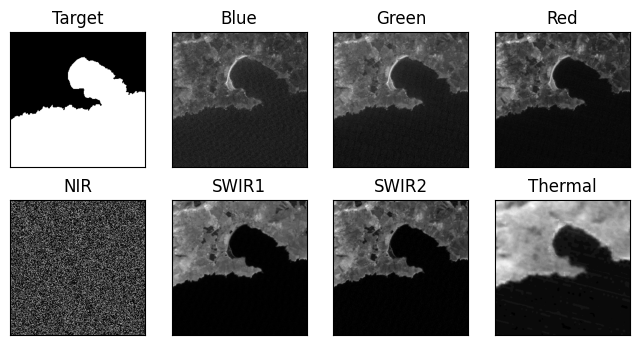

In [14]:
# Band names
band_names = {0: 'Blue', 1: 'Green', 2: 'Red', 3: 'NIR', 4: 'SWIR1', 5: 'SWIR2', 6: 'Thermal'}

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
axs = axs.flatten()

# Plot target
axs[0].imshow(target[1], cmap='gray')
axs[0].set_title('Target')
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot bands
for i in range(7):
    axs[i+1].imshow(bands[i], cmap='gray')
    axs[i+1].set_title(band_names[i])
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])

In [7]:
# Download the model directly from Hugging Face
model_path = hf_hub_download(
    repo_id="a-data-odyssey/coastal-image-segmentation", 
    filename="LICS_FINETUNE_26JUL24.pth")

# Load the model
model = torch.load(model_path)

# Set the model to evaluation mode
device = torch.device('mps' if torch.backends.mps.is_built() 
                      else 'cuda' if torch.cuda.is_available() 
                      else 'cpu')
model.to(device)
model.eval()  

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_76382/1663362717.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [15]:
# Make a prediction
input = bands.to(device)
input = input.unsqueeze(0)
output = model(input)

print(target.shape)
print(output.shape)

torch.Size([2, 256, 256])
torch.Size([1, 2, 256, 256])


In [16]:
# Get the water mask 
target_water = np.argmax(target, axis=0)

# Get the predicted water mask
output = output.cpu().detach().numpy().squeeze()
output = np.argmax(output, axis=0)

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_76382/2111031628.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  accuracy = np.mean(np.array(target_water == output))


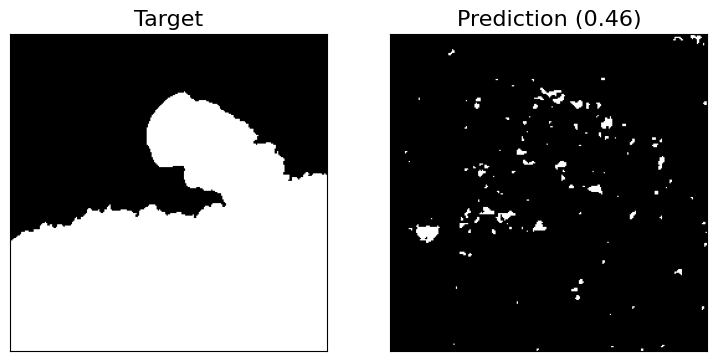

In [17]:
# Plot the prediction
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(target_water, cmap='gray')
axs[0].set_title('Target', fontsize=16)

axs[1].imshow(output, cmap='gray')

accuracy = np.mean(np.array(target_water == output))
accuracy = round(accuracy, 3)
axs[1].set_title(f'Prediction ({accuracy})', fontsize=16)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# PCI from scratch

In [2]:
def performance_metric(targets, predictions, type='segmentation'):
    """Calculate the performance metric for the model"""

    targets = np.array(targets)
    predictions = np.array(predictions)

    if type == 'segmentation':
        # Calculate average accuracy
        accuracy_list = []
        for t,p in zip(targets, predictions):
            accuracy = np.mean(t == p)
            accuracy_list.append(accuracy)

        metric = np.mean(accuracy_list)
    if type == 'classification':
        # Calculate accuracy
        metric = np.mean(targets == predictions)


    return metric

In [3]:
def shuffle_channel(img, channel):
        """Shuffle a given channel of an image
            img: tensor, image to shuffle with shape (batch, channels, height, width)
            channel: int, channel to shuffle"""

        # Get size of the image
        size_x = img.shape[2]
        size_y = img.shape[3]

        # Flatten the channel
        perm_img = img.to('cpu').detach().numpy()
        perm_channel = perm_img[0][channel]
        perm_channel = perm_channel.ravel()

        # Shuffle the channel
        random.shuffle(perm_channel)
        perm_channel.resize(size_x,size_y)
        perm_img[0][channel] = perm_channel

        #Convert to tensor
        perm_img = torch.tensor(perm_img)
        
        return perm_img

In [4]:
def get_permuted_performance(model, dataset, channel=-1, type='segmentation'):
    """Calculate the performance metric for the model with permuted data"""

    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    targets = []
    outputs = []

    for image, target in iter(data_loader):

        # Format target
        target = target.numpy().squeeze()
        target = np.argmax(target, axis=0)

        # Permuted image
        if channel != -1:
            image = shuffle_channel(image, channel)

        # Get prediction
        image = image.to(device)
        output = model(image)

        output = output.cpu().detach().numpy().squeeze()
        output = np.argmax(output, axis=0)

        # Append to list
        targets.append(target)
        outputs.append(output)
    
    metric = performance_metric(targets, outputs, type=type)

    return metric

In [20]:
# Get baseline performance 
baseline = get_permuted_performance(model, lics_dataset, channel=-1, type='segmentation')
print(f'Baseline accuracy: {np.round(baseline,3)}')

Baseline accuracy: 0.985


In [24]:
# Get nir performance
nir = get_permuted_performance(model, lics_dataset, channel=3, type='segmentation')
print(f'NIR accuracy: {np.round(nir,3)}')
print(f'PCI: {np.round(baseline - nir,3)}')

NIR accuracy: 0.605
PCI: 0.381


In [25]:
pci_scores = []

# Repeat for all channels
for channel in tqdm([0,1,2,3,4,5,6]):
    # Repeate the calculation 3 times
    metrics = []
    for r in range(3):
        metric = get_permuted_performance(model, lics_dataset, channel=channel, type='segmentation')
        metrics.append(metric)

    # Calculate PCI    
    pci = baseline - np.mean(metrics)
    pci_scores.append(pci)

100%|██████████| 7/7 [02:47<00:00, 23.97s/it]


Text(0.5, 0, 'Spectral Band')

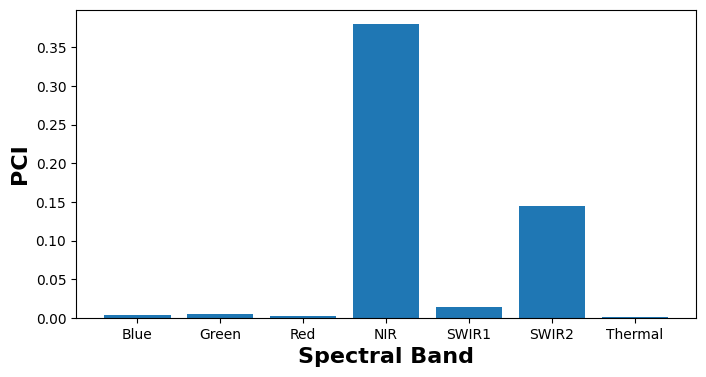

In [26]:
# Plot the PCI scores
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.bar(band_names.values(), pci_scores)

ax.set_ylabel('PCI', fontsize=16, fontweight='bold')
ax.set_xlabel('Spectral Band', fontsize=16, fontweight='bold')

## Figures for theory section 

80


(np.float64(-0.5), np.float64(255.5), np.float64(185.5), np.float64(-0.5))

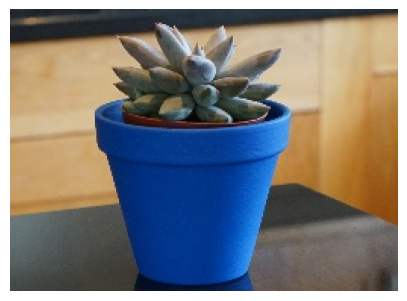

In [5]:
# Load data
paths = glob.glob("../../data/pot_plants/test/*")
print(len(paths))

# Plot Image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
img = plt.imread(paths[6])

#crop image y1:y2
img = img[20:206, 0:256]
ax.imshow(img)
ax.axis("off")

In [ ]:
# Cover image
fig, ax = plt.subplots(3, 3, figsize=(8, 5))

for i in range(3):

    # Get RGB channels
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]


    if i == 0:
        R = R.ravel()
        random.shuffle(R)
        R.resize(186,256)
    elif i == 1:
        G = G.ravel()
        random.shuffle(G)
        G.resize(186,256)
    else:
        B = B.ravel()
        random.shuffle(B)
        B.resize(186,256)


    ax[i,0].imshow(R,cmap='Reds')
    ax[i,1].imshow(G,cmap='Greens')
    ax[i,2].imshow(B,cmap='Blues')

for a in ax.flatten():
    a.axis("off")

# Save figure
save_fig('PCI_cover_image')

In [ ]:
#Get image
img = plt.imread(paths[31])

# Get RGB channels
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]

#Permute the red band
R_perm = R.copy()
R_perm = R_perm.ravel()
random.shuffle(R_perm)
R_perm.resize(256,256)

# Plot RGB channels
fig, ax = plt.subplots(2, 4, figsize=(10, 5))

ax[0,0].imshow(img)
ax[0,0].set_title("Original Image")

ax[0,1].imshow(R, cmap="Reds")
ax[0,1].set_title("R")

ax[0,2].imshow(G, cmap="Greens")
ax[0,2].set_title("G")

ax[0,3].imshow(B, cmap="Blues")
ax[0,3].set_title("B")

perm_img = np.stack([R_perm, G, B], axis=-1)

ax[1,0].imshow(perm_img)
ax[1,0].set_title("Permuted Image")

ax[1,1].imshow(R_perm, cmap="Reds")
ax[1,1].set_title("R")

ax[1,2].imshow(G, cmap="Greens")
ax[1,2].set_title("G")

ax[1,3].imshow(B, cmap="Blues")
ax[1,3].set_title("B")

for a in ax.flatten():
    a.axis("off")

### PCI for pot plant classification

In [6]:
# Download the model directly from Hugging Face Hub
model_path = hf_hub_download(repo_id="a-data-odyssey/pot-plant-classifier", filename="pot-plant-classifier.pth")

# Load the model
model = torch.load(model_path)
model.eval()  # Set the model to evaluation mode

# set the device
device = torch.device('mps' if torch.backends.mps.is_built() else 'cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the data
base_path = "/Users/conorosullivan/Documents/git/XAI-for-CV/data/pot_plants/"
val_paths = glob.glob(base_path + "/val/*.jpg")
print(len(val_paths))

num_classes = 4
val_data = ImageDataset(val_paths,num_classes)

200


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_6433/3456071324.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

paths_0 = glob.glob(base_path + "/val/0_*.jpg")
img = plt.imread(paths_0[0])
ax[0].imshow(img)
ax[0].set_title("Rudo", fontsize=30)

paths_1 = glob.glob(base_path + "/val/1_*.jpg")
img = plt.imread(paths_1[4])
ax[1].imshow(img)
ax[1].set_title("Baya", fontsize=30)

paths_2 = glob.glob(base_path + "/val/2_*.jpg")
img = plt.imread(paths_2[2])
ax[2].imshow(img)
ax[2].set_title("Greg", fontsize=30)

paths_3 = glob.glob(base_path + "/val/3_*.jpg")
print(len(paths_3))
img = plt.imread(paths_3[0])
ax[3].imshow(img)
ax[3].set_title("Yuki", fontsize=30)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

In [7]:
# Get baseline performance 
baseline = get_permuted_performance(model, val_data, channel=-1, type='classification')
print(f'Baseline accuracy: {np.round(baseline,4)}')

red = get_permuted_performance(model, val_data, channel=0, type='classification')
print(f'Red PCI: {np.round(baseline-red,4)}')

green = get_permuted_performance(model, val_data, channel=1, type='classification')
print(f'Green PCI: {np.round(baseline-green,4)}')

blue = get_permuted_performance(model, val_data, channel=2, type='classification')
print(f'Blue PCI: {np.round(baseline-blue,4)}')

Baseline accuracy: 0.94
Red PCI: 0.335
Green PCI: 0.38
Blue PCI: 0.355


In [49]:
def get_PCI_for_class(model,base_path,class_int):
    # Load the data
    val_paths = glob.glob(base_path + f"/val/{class_int}_*.jpg")
    print(f"Class {class_int}: {len(val_paths)}")

    num_classes = 4
    val_data = ImageDataset(val_paths,num_classes)

    # Get baseline performance 
    baseline = get_permuted_performance(model, val_data, channel=-1, type='classification')
    print(f'Baseline accuracy: {np.round(baseline,4)}')

    pci = []
    for i in range(3):
        metric = get_permuted_performance(model, val_data, channel=i, type='classification')
        pci.append(baseline - metric)
        print(f'PCI for {i}: {np.round(baseline - metric,4)}')
    
    print()

    return pci

In [ ]:
# Get PCI for each class
rudo_pci = get_PCI_for_class(model,base_path,0)
baya_pci = get_PCI_for_class(model,base_path,1)
greg_pci = get_PCI_for_class(model,base_path,2)
yuki_pci = get_PCI_for_class(model,base_path,3)

In [41]:
# Reorder the PCI scores
red_pci = [rudo_pci[0],baya_pci[0],greg_pci[0],yuki_pci[0]]
green_pci = [rudo_pci[1],baya_pci[1],greg_pci[1],yuki_pci[1]]
blue_pci = [rudo_pci[2],baya_pci[2],greg_pci[2],yuki_pci[2]]

In [ ]:
# Plot bar plot of PCI scores
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
barWidth = 0.2

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

ax.bar(r1, red_pci, color='r', width=barWidth, edgecolor='grey', label='Red')
ax.bar(r2, green_pci, color='g', width=barWidth, edgecolor='grey', label='Green')
ax.bar(r3, blue_pci, color='b', width=barWidth, edgecolor='grey', label='Blue')

# Add xticks on the middle of the group bars
ax.set_xlabel('Pot Plant', fontweight='bold')
ax.set_ylabel('PCI', fontweight='bold')
ax.set_xticks([r + barWidth for r in range(4)])
ax.set_xticklabels(['Rudo','Baya','Greg','Yuki'])

# Create legend & Show graphic
ax.legend()
